In [1]:
%matplotlib ipympl

__requires__ = "numpy==1.24"

import pkg_resources
pkg_resources.require(__requires__)

import multiprocessing as mp
import numpy as np
print(np. __version__)
import pandas as pd
from numba import njit, jit
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import seaborn as sb
import time
import pprint

from IPython.display import display
from ipywidgets import interactive
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

# Import own code
from default_constants import *
from algorithms import *
from signal_data_class import *
from interactive_trigger_class import *
from plot_data import *

sb.set()
pp = pprint.PrettyPrinter(indent=4)

SN1 = "../data/SN1_Chirp_300kHzTemplate_0p16SNR_280Start_Sig.npy"  # Nasty noise
SN2 = "../data/SN2_Chirp_300kHzTemplate_0p32SNR_280Start_Sig.npy"  # Nice noise
SX1 = "../data/SX1_ChirpSig_ChirpTemplate_325p5kHz_3p45e8Grad_1024pt_99mV.npy"
SX2 = "../data/SX2_ChirpSig_ChirpTemplate_325p5kHz_3p45e8Grad_1024pt_132mV.npy"
SX3 = "../data/SX3_ChirpSig_ChirpTemplate_325p5kHz_3p45e8Grad_1024pt_264mV.npy"
XN1 = "../data/XN1_Chirp_300kHzTemplate_0p16SNR_280Start_Noise.npy"
XN2 = "../data/XN2_Chirp_300kHzTemplate_0p32SNR_280Start_Noise.npy"

data = {}
# data["SN1"] = np.array(list( zip(*np.load(SN1)) ))
# data["SN2"] = np.array(list( zip(*np.load(SN2)) ))
data["SX1"] = np.array(list( zip(*np.load(SX1)) ))
# data["SX2"] = np.array(list( zip(*np.load(SX2)) ))
# data["SX3"] = np.array(list( zip(*np.load(SX3)) ))
data["XN1"] = np.array(list( zip(*np.load(XN1)) ))
# data["XN2"] = np.array(list( zip(*np.load(XN2)) ))


1.24.0


In [2]:
image1 = InteractiveTrigger(
        data["SX1"],
        slice_start=0,
        slice_end=3000,
        zero_detector_alg=zero_detector2,
    )

interact(image1.update,
      delay_samples=widgets.IntSlider(min=0, max=300, step=1, value=DELAY_SAMPLES), 
      inv_frac=widgets.FloatSlider(min=0, max=6, step=0.1, value=INV_FRAC)
    )


interactive(children=(IntSlider(value=100, description='delay_samples', max=300), FloatSlider(value=3.7, descr…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

sample_spacing 1e-06
pulse_spacing 0.002 (2ms)

samples_per_chirp: 2000
samples: 1006484
chirp_no: 503.242
samples_trunc: 1006000
chirp_no_trunc: 503

mean: 1594


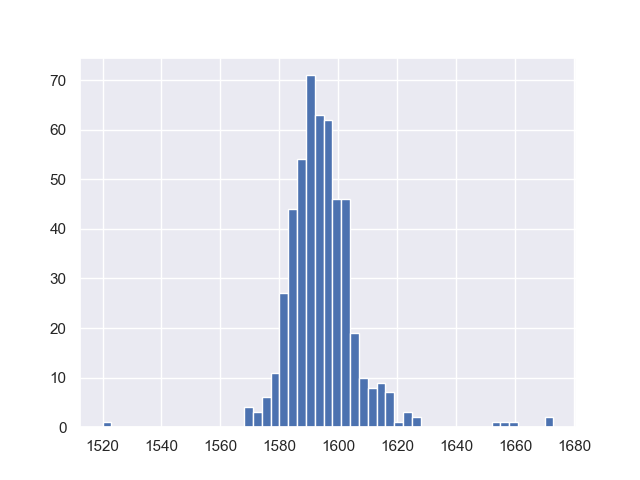

In [3]:
# Create truth data for SX1

# Find position of chirp per cycle

t = data["SX1"][0]
sig = data["SX1"][1]

sample_spacing = 1e-6
pulse_spacing = 2e-3  # 2ms
print("sample_spacing", sample_spacing)
print("pulse_spacing", pulse_spacing, "(2ms)")
print()

samples_per_chirp = int(pulse_spacing / sample_spacing)
samples = len(t)
chirp_no = samples / samples_per_chirp

print("samples_per_chirp:", samples_per_chirp)
print("samples:", samples)
print("chirp_no:", chirp_no)

samples_trunc = samples - (samples % samples_per_chirp)
chirp_no_trunc = samples_trunc // samples_per_chirp
print("samples_trunc:", samples_trunc)
print("chirp_no_trunc:", chirp_no_trunc)

t_trunc = t[:samples_trunc]
sig_trunc = sig[:samples_trunc]

chirp_sections = []
for i in range(chirp_no_trunc-1):
    section_start = samples_per_chirp * i
    section_end = samples_per_chirp * (i + 1)
    t_section = t[section_start:section_end]
    sig_section = sig[section_start:section_end]
    chirp_section = (t_section, sig_section)
    chirp_sections.append(chirp_section)

tops = []
for t_section, sig_section in chirp_sections:
    max_idx = np.argmax(sig_section)
    tops.append(max_idx)

print()
mean = int(np.mean((tops)))
print("mean:", mean)

fig, axis = plt.subplots()
axis.hist(tops, bins="auto")

# Create truth data
SX1_truth_data = np.zeros(1006484)
for i in range(chirp_no_trunc):
    idx_of_chirp = samples_per_chirp * i + mean
    SX1_truth_data[idx_of_chirp] = True


In [4]:
# x = np.arange(100).reshape(10, 10)

# @jit(nopython=True)
# def go_fast(a): # Function is compiled and runs in machine code
#     trace = 0.0
#     for i in range(a.shape[0]):
#         trace += np.tanh(a[i, i])
#     return a + trace

# # DO NOT REPORT THIS... COMPILATION TIME IS INCLUDED IN THE EXECUTION TIME!
# start = time.time()
# go_fast(x)
# end = time.time()
# print("Elapsed (with compilation) = %s" % (end - start))

# # NOW THE FUNCTION IS COMPILED, RE-TIME IT EXECUTING FROM CACHE
# start = time.time()
# go_fast(x)
# end = time.time()
# print("Elapsed (after compilation) = %s" % (end - start))


In [5]:
# %%time

t1 = SignalData(data["SX1"],
                truth_data = SX1_truth_data,
                zero_detector_alg=zero_detector2,
                slice_start = 0,
                slice_end = 50000,
               )

inv_frac_vals = np.arange(1, 6, 0.5)
delay_samples_vals = np.arange(50, 250, 25)

t1_all_test_params = t1.get_performance(inv_frac_vals = inv_frac_vals,
                                        delay_samples_vals = delay_samples_vals,
                                        tolerance = 100e-6,
                                        verbose = True,
                                       )
t1_pd = pd.DataFrame(t1_all_test_params)  # Faster to pass list of dicts than to add rows iteratively
t1_pd.to_csv("t1_performance_data.temp")


.......... 50
..........
.......... 75
..........
.......... 100
..........
.......... 125
..........
.......... 150
..........
.......... 175
..........
.......... 200
..........
.......... 225
..........
computation completed


In [6]:
# # %%time

# start = time.time()
# t1_all_test_params = t1.get_performance_jit(inv_frac_vals = inv_frac_vals,
#                                         delay_samples_vals = delay_samples_vals,
#                                         tolerance = 100e-6,
#                                         verbose = True,
#                                        )
# t1_pd = pd.DataFrame(t1_all_test_params)  # Faster to pass list of dicts than to add rows iteratively
# t1_pd.to_csv("t1_performance_data.temp")
# end = time.time()
# print("Elapsed (with compilation) = %s" % (end - start))


# start = time.time()
# t1_all_test_params = t1.get_performance_jit(inv_frac_vals = inv_frac_vals,
#                                         delay_samples_vals = delay_samples_vals,
#                                         tolerance = 100e-6,
#                                         verbose = True,
#                                        )
# t1_pd = pd.DataFrame(t1_all_test_params)  # Faster to pass list of dicts than to add rows iteratively
# t1_pd.to_csv("t1_performance_data.temp")
# end = time.time()
# print("Elapsed (after compilation) = %s" % (end - start))


In [7]:
# %%time

# t1_all_test_params = t1.get_performance_parallel(inv_frac_vals = inv_frac_vals,
#                                                  delay_samples_vals = delay_samples_vals,
#                                                  tolerance = 100e-6,
#                                                  verbose = True,
#                                                 )
# t1_pd = pd.DataFrame(t1_all_test_params)  # Faster to pass list of dicts than to add rows iteratively
# t1_pd.to_csv("t1_performance_data.temp")


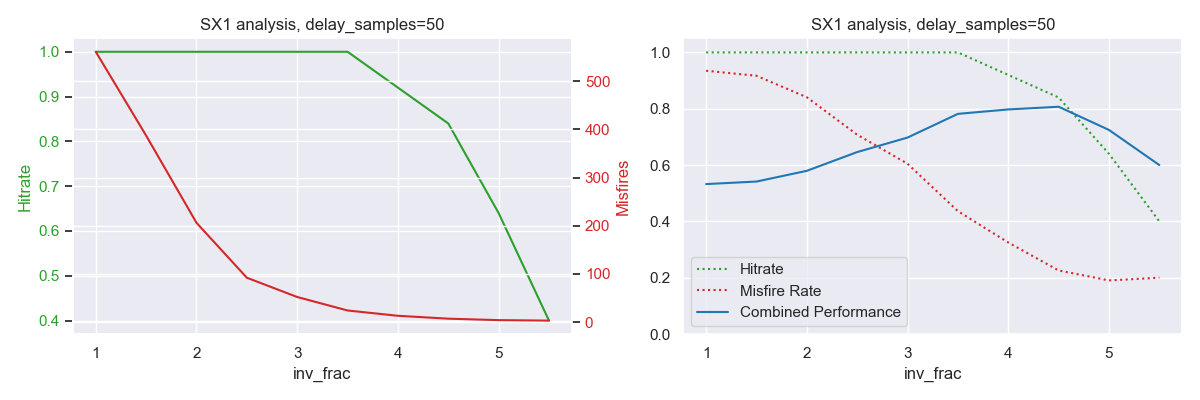

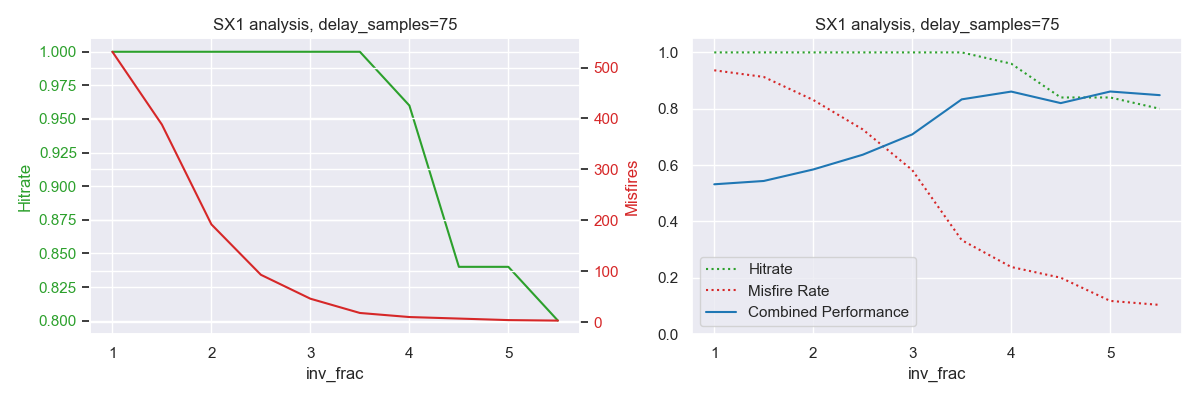

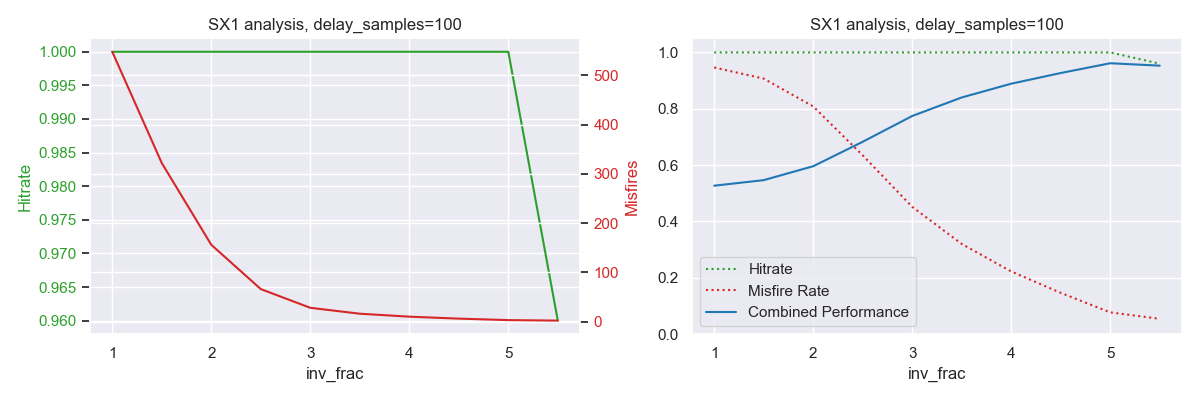

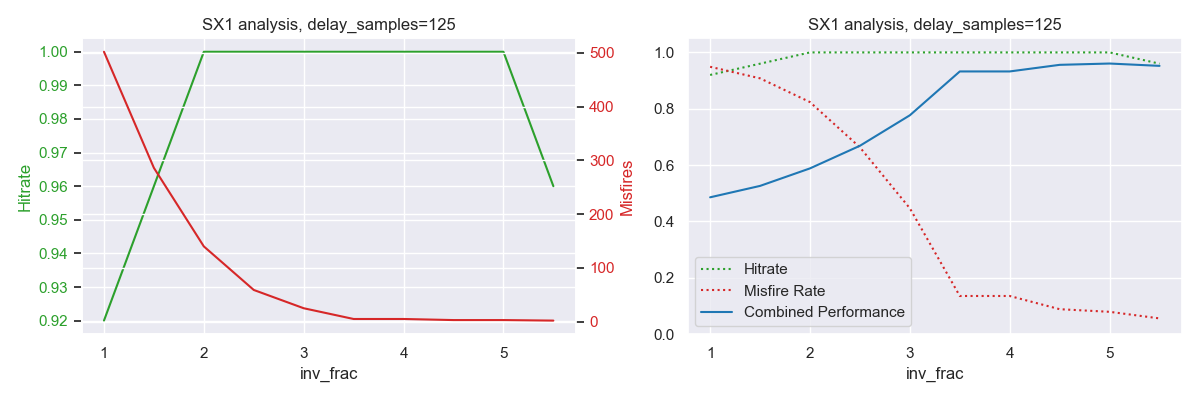

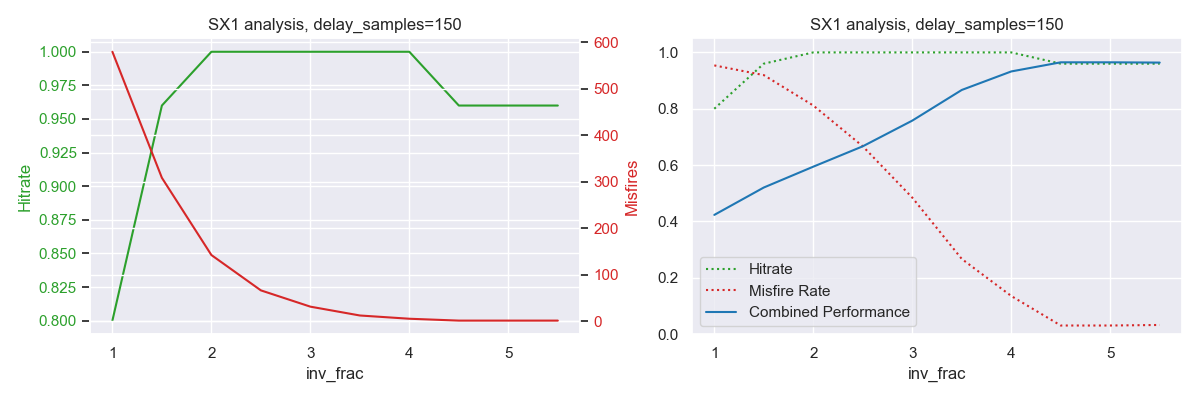

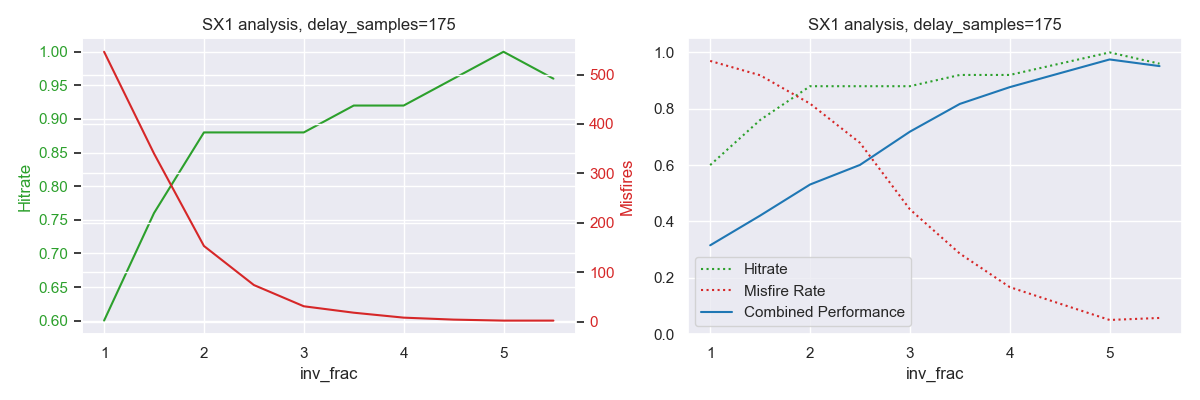

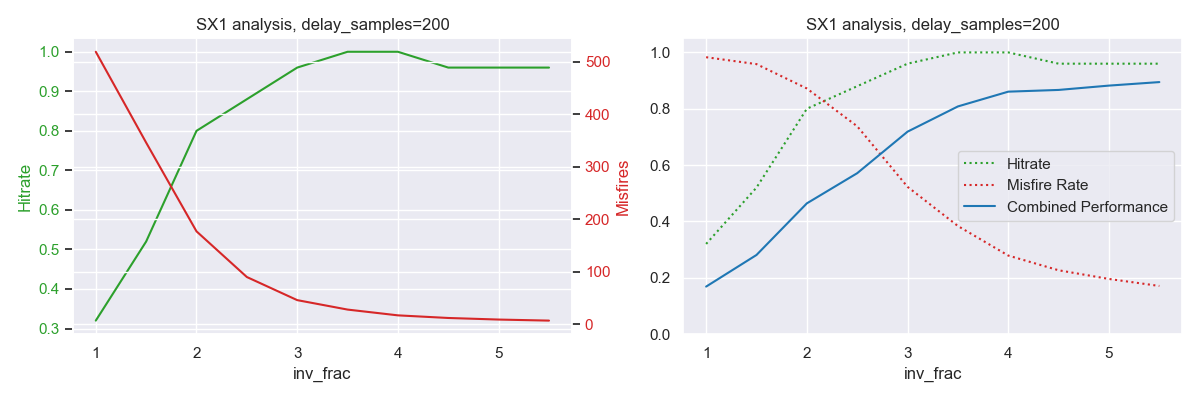

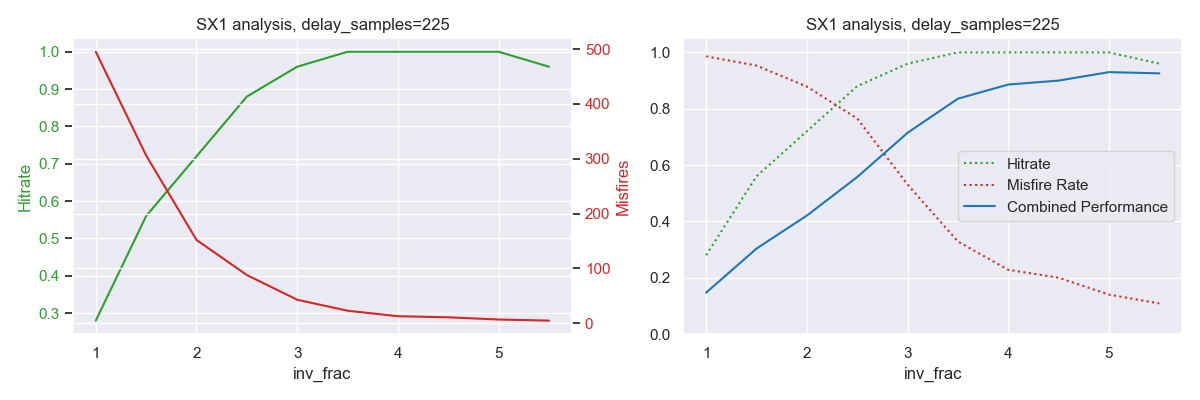

In [8]:
t1_pd_analyse = pd.read_csv("t1_performance_data.temp")

for ds in delay_samples_vals:
    plot_inv_frac(t1_pd_analyse, delay_samples=ds)


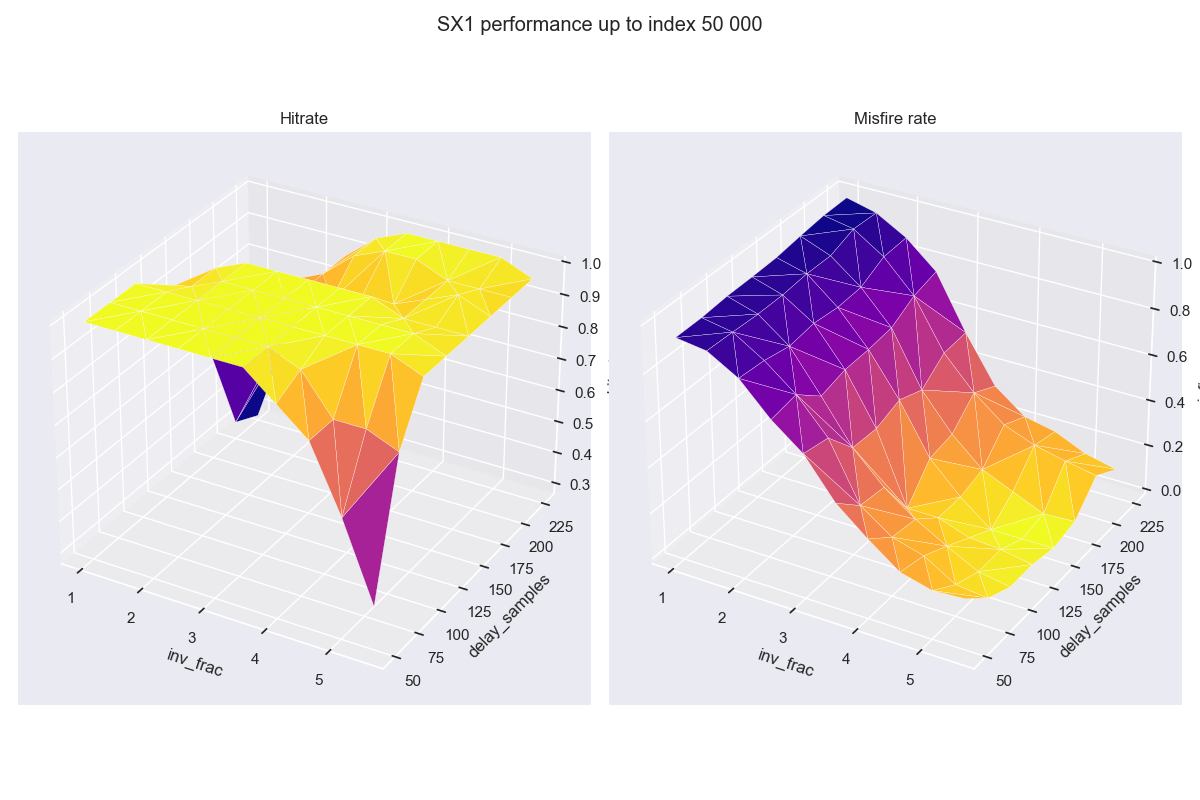

In [9]:
t1_pd_analyse = pd.read_csv("t1_performance_data.temp")
plot_all_3d(t1_pd_analyse, title="SX1 performance up to index 50 000")


In [10]:
# t2 = SignalData(data["SX1"], 
#                 truth_data = SX1_truth_data,
#                 zero_detector_alg=zero_detector2,
#                )

# inv_frac_vals = np.arange(2, 7 + 0.25, 0.25)  # Add step size to endpoint to include endpoint
# delay_samples_vals = np.arange(50, 350 + 15, 15)  # Add step size to endpoint to include endpoint

# start = time.time()
# t2_all_test_params = t2.get_performance(inv_frac_vals = inv_frac_vals,
#                                         delay_samples_vals = delay_samples_vals,
#                                         tolerance = 100e-6,
#                                         verbose = True,
#                                        )
# end = time.time()
# print("Elapsed (with compilation) = %s" % (end - start))

# t2_pd = pd.DataFrame(t2_all_test_params)  # Faster to pass list of dicts than to add rows iteratively
# t2_pd.to_csv("t2_performance_data.temp")


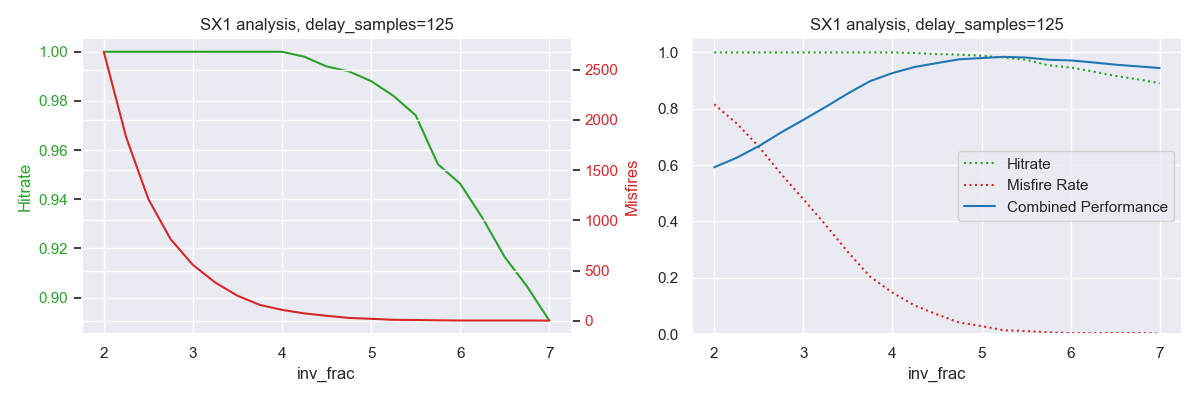

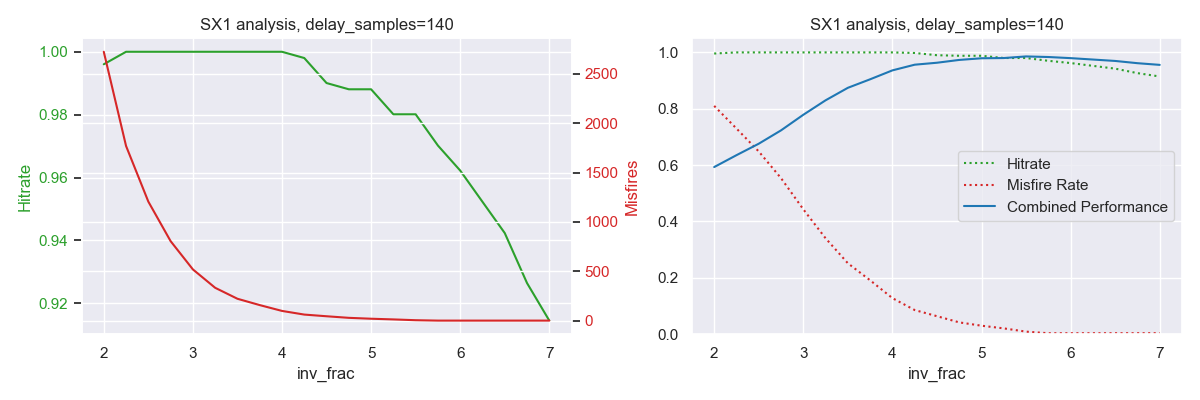

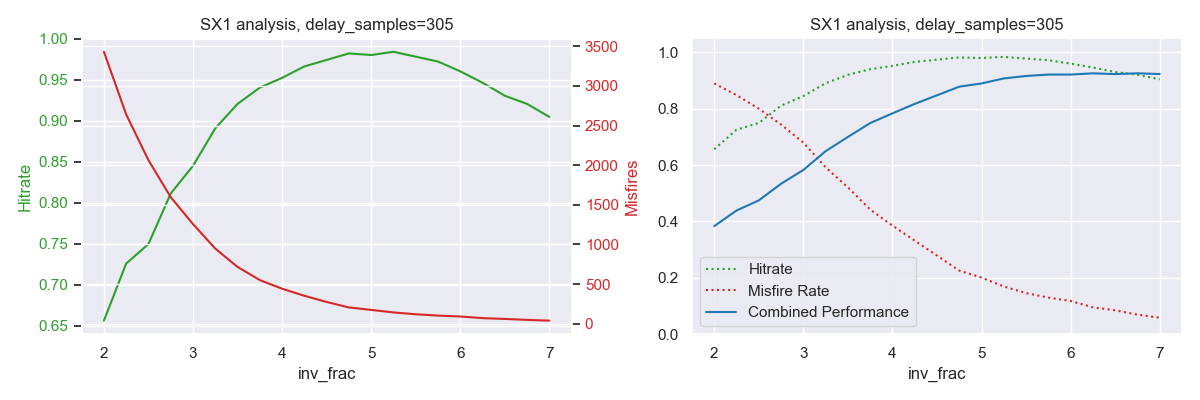

In [11]:
t2_pd_analyse = pd.read_csv("../data/t2_performance_data 2023 08 21 - SX1 8hr computation")

plot_inv_frac(t2_pd_analyse, delay_samples=125)
plot_inv_frac(t2_pd_analyse, delay_samples=140)
plot_inv_frac(t2_pd_analyse, delay_samples=305)

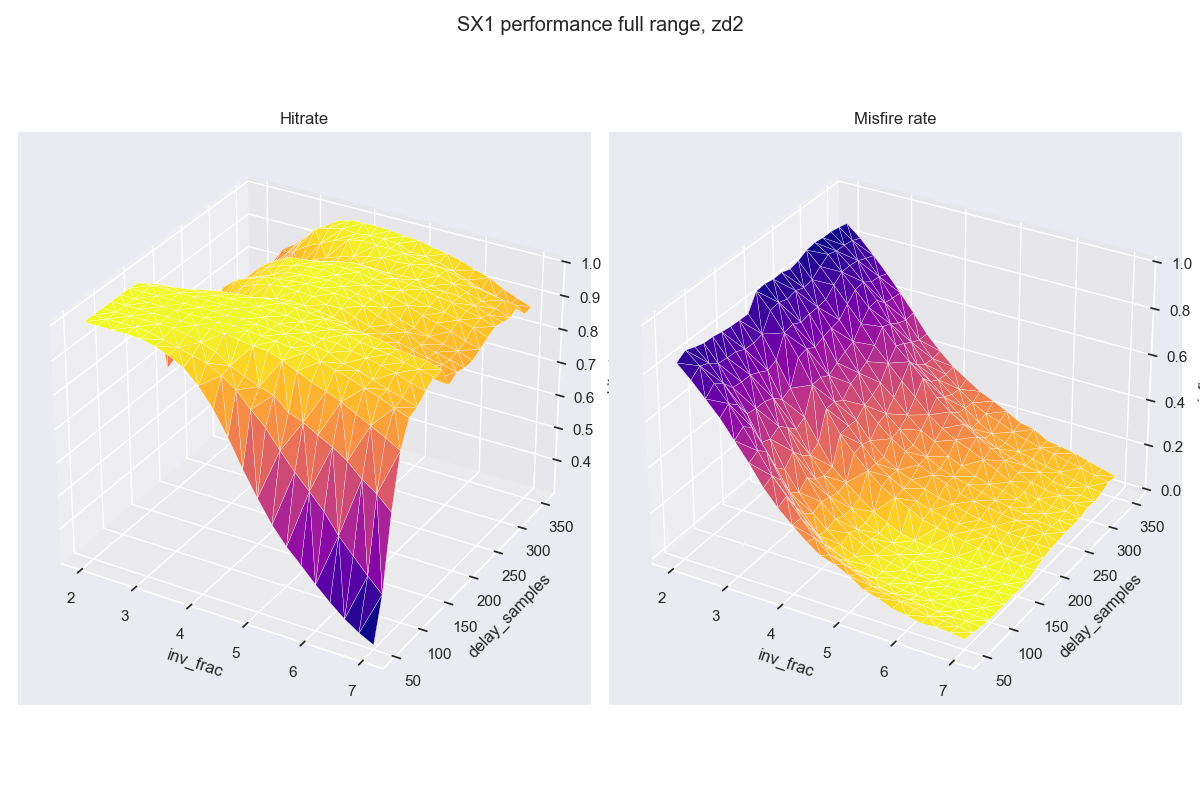

In [12]:
t2_pd_analyse = pd.read_csv("../data/t2_performance_data 2023 08 21 - SX1 8hr computation")
plot_all_3d(t2_pd_analyse, title="SX1 performance full range, zd2")


In [13]:
# Make sig + noise, SX1+XN1, using SX1 truth data

SX1_t, SX1_sig = data["SX1"]
XN1_t, XN1_sig = data["XN1"]

print("len(SX1_t):", len(SX1_t))
print("len(XN1_t):", len(XN1_t))
trim = min(len(SX1_t), len(XN1_t))
SX1_sig = np.array(SX1_sig[:trim])
XN1_sig = np.array(XN1_sig[:trim])
print(f"Is time series (trimmed to [:{trim}]) of SX1 & XN1 the same?:", SX1_sig == XN1_sig)

combo_t = SX1_t[:trim]
combo_sig = SX1_sig + XN1_sig

data["SX1+XN1"] = [combo_t, combo_sig]


len(SX1_t): 1006484
len(XN1_t): 3010216
Is time series (trimmed to [:1006484]) of SX1 & XN1 the same?: [False False False ... False False False]


In [14]:
image2 = InteractiveTrigger(
        data["SX1+XN1"],
        slice_start=0,
        slice_end=3000,
        zero_detector_alg=zero_detector2,
    )

interact(image2.update,
      delay_samples=widgets.IntSlider(min=0, max=300, step=1, value=DELAY_SAMPLES), 
      inv_frac=widgets.FloatSlider(min=0, max=6, step=0.1, value=INV_FRAC)
    )


interactive(children=(IntSlider(value=100, description='delay_samples', max=300), FloatSlider(value=3.7, descr…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

In [15]:
# %%time

# t3 = SignalData(data["SX1+XN1"], 
#                 truth_data = SX1_truth_data,
#                 zero_detector_alg=zero_detector2,
#                )

# inv_frac_vals = np.arange(2, 7 + 0.25, 0.25)  # Add step size to endpoint to include endpoint
# delay_samples_vals = np.arange(50, 350 + 15, 15)  # Add step size to endpoint to include endpoint
# t3_all_test_params = t3.get_performance(inv_frac_vals = inv_frac_vals,
#                                         delay_samples_vals = delay_samples_vals,
#                                         tolerance = 100e-6,
#                                         verbose = True,
#                                        )
# t3_pd = pd.DataFrame(t3_all_test_params)  # Faster to pass list of dicts than to add rows iteratively
# t3_pd.to_csv("t3_performance_data.temp")
